# Image Processing for Panoramic Teeth X-ray
## INF573 Final Report

#####Mahmoud Yamani mahmoud.yamani@polytechnique.edu
#####Alina Sarzhanova alina.sarzhanova@polytechnique.edu

Import necessary libraries

In [1]:
!git clone https://github.com/mymni/teeth-xray-detect.git

Cloning into 'teeth-xray-detect'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 8.84 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
import os
import cv2
import numpy as np
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

Upload the image

In [3]:
image_path = "/content/teeth-xray-detect/original.png"
image = cv2.imread(image_path)

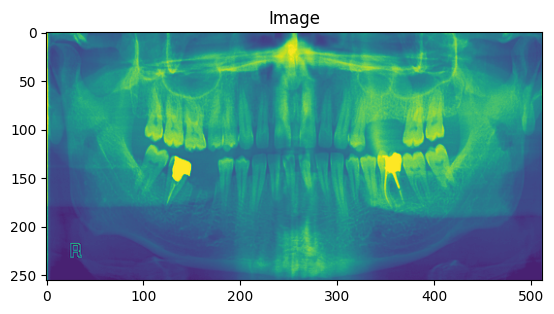

In [ ]:
image = cv2.resize(image, (512, 256))

image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

bw_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.title("Image")
plt.imshow(bw_image)

Darken the image

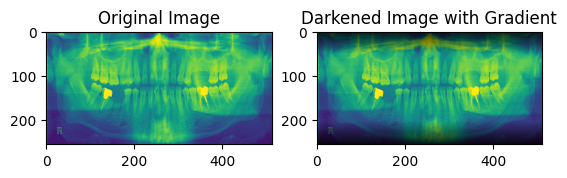

In [ ]:
rows, cols, _ = image.shape
mask = np.ones((rows, cols), dtype=float)

gradient_length = int(0.2*rows)

for i in range(gradient_length):
    i_val = 0.8*(i)/gradient_length + 0.2
    mask[i] = np.linspace(i_val, i_val, cols)
    mask[rows - 1 - i] = np.linspace(i_val, i_val, cols)

darkened_image = (image * mask[:, :, np.newaxis]).astype('uint8')

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Darkened Image with Gradient")
plt.imshow(cv2.cvtColor(darkened_image, cv2.COLOR_BGR2RGB))

plt.show()

Apply Laplacian to the darkened image

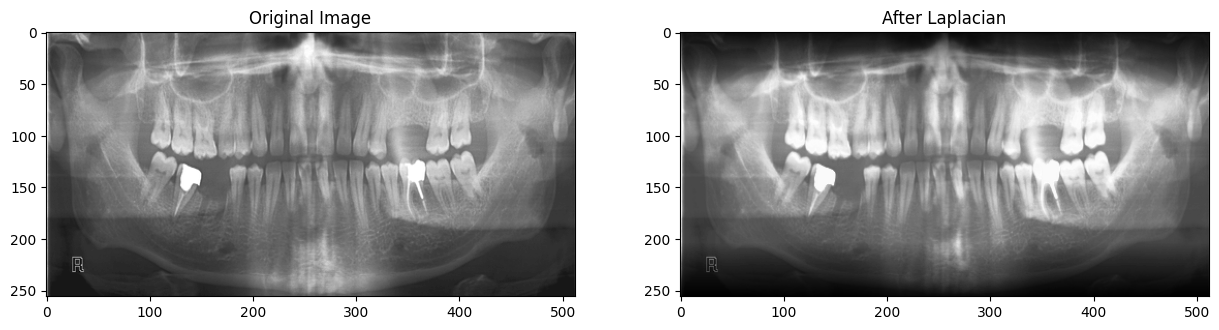

In [ ]:
def laplacian(image):
  g0=cv2.pyrDown(image)
  g1=cv2.pyrDown(g0)
  g2=cv2.pyrDown(g1)
  g3=cv2.pyrDown(g2)
  g4=cv2.pyrDown(g3)
  g5=cv2.pyrDown(g4)
  g6=cv2.pyrDown(g5)
  h5=cv2.pyrUp(g6)
  h4=cv2.pyrUp(h5)
  h3=cv2.pyrUp(h4)
  h2=cv2.pyrUp(h3)
  h1=cv2.pyrUp(h2)
  h0=cv2.pyrUp(h1)
  originallvl=cv2.pyrUp(h0)

  x,y,z=originallvl.shape
  image=cv2.resize(image,(y,x))

  g0=cv2.pyrDown(image)
  g1=cv2.pyrDown(g0)
  g2=cv2.pyrDown(g1)
  g3=cv2.pyrDown(g2)
  g4=cv2.pyrDown(g3)
  g5=cv2.pyrDown(g4)
  g6=cv2.pyrDown(g5)
  h5=cv2.pyrUp(g6)
  h4=cv2.pyrUp(h5)
  h3=cv2.pyrUp(h4)
  h2=cv2.pyrUp(h3)
  h1=cv2.pyrUp(h2)
  h0=cv2.pyrUp(h1)
  l0=cv2.subtract(g0,h0)

  lr0=cv2.resize(l0,(y,x))
  norm0=cv2.normalize(lr0,None,0,255,cv2.NORM_MINMAX)

  rn0=cv2.add(image,lr0)
  new_image = cv2.convertScaleAbs(rn0, alpha= 1, beta=5)

  return rn0

lapl_image = laplacian(darkened_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.title("After Laplacian")
plt.imshow(cv2.cvtColor(lapl_image, cv2.COLOR_BGR2GRAY), cmap = 'gray')

Apply automatic brightness and contrast adjustment

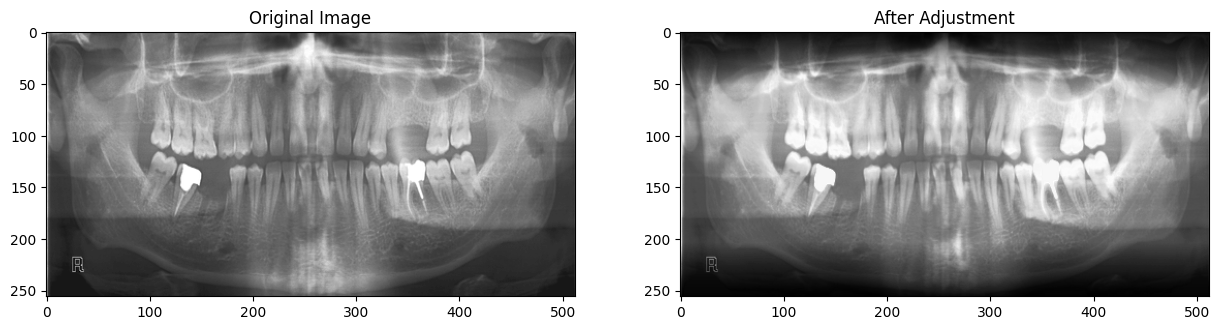

In [ ]:
import cv2
import matplotlib.pyplot as plt

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_size = len(hist)
    accumulator = [float(hist[0])]

    for index in range(1, hist_size):
        accumulator.append(accumulator[index - 1] + float(hist[index]))

    maximum = accumulator[-1]
    clip_hist_percent *= (maximum / 100.0)
    clip_hist_percent /= 2.0

    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    maximum_gray = hist_size - 1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    auto_result = cv2.cvtColor(auto_result, cv2.COLOR_BGR2GRAY)

    return (auto_result, alpha, beta, hist)

contr_image, alpha, beta, hist = automatic_brightness_and_contrast(lapl_image)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(bw_image, cmap="gray")

plt.subplot(122)
plt.title("After Adjustment")
plt.imshow(contr_image, cmap="gray")

Drawing contours and hulls on the original image

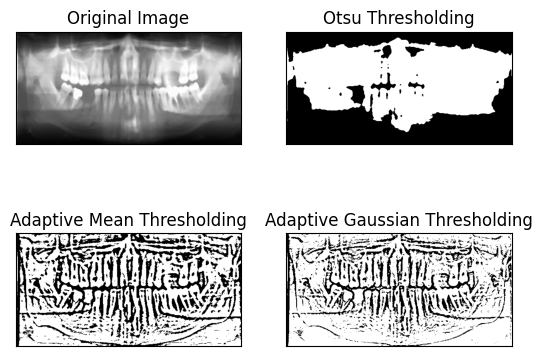

26


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = contr_image
img = cv.medianBlur(img,5)

ret,th1 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Otsu Thresholding',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

contours, hierarchy = cv.findContours(th1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
i=cv.drawContours(th1, contours, -1, (100,100,100), 10)
print(len(contours))
cv.imwrite('contor.jpg',i)
f=cv.imread('original.png')

# drawing contours + hull results
hull_list = []
for i in range(len(contours)):
    hull = cv.convexHull(contours[i])
    hull_list.append(hull)
drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (100,100,100)
    cv.drawContours(f, contours, i, (255,255,255))
    cv.drawContours(f, hull_list, i, color)

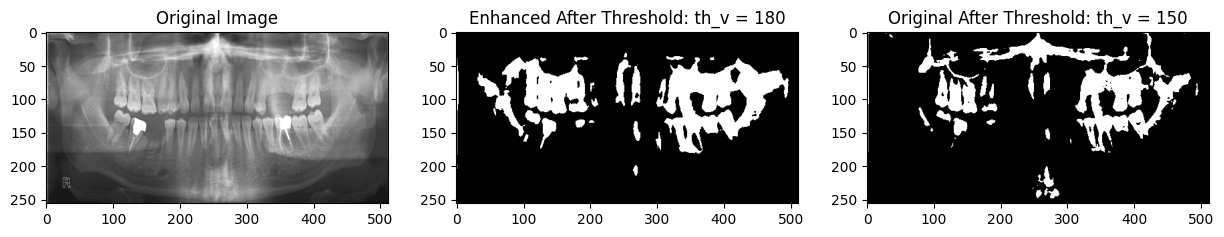

In [ ]:
def thesholding(img, thresh):
    blur = cv2.GaussianBlur(img,(5,5),0)
    _,thresh_img = cv2.threshold(blur,thresh,255,cv2.THRESH_BINARY)
    return thresh_img

thresh = 180
img = contr_image
thresh_img = thesholding(img, thresh)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(bw_image, cmap="gray")

plt.subplot(132)
plt.title("Enhanced After Threshold: th_v = "+str(thresh))
plt.imshow(thresh_img, cmap="gray")

thresh = 150
img = bw_image
thresh_img2 = thesholding(img, thresh)

plt.subplot(133)
plt.title("Original After Threshold: th_v = "+str(thresh))
plt.imshow(thresh_img2, cmap="gray")


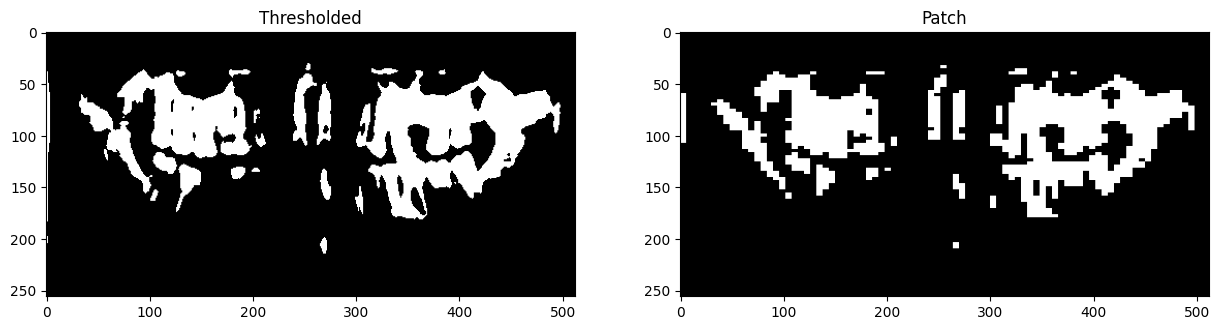

In [ ]:
def patching(img1):
    img = img1.copy()
    sizeY = img.shape[0]
    sizeX = img.shape[1]
    nRows = 85 # new patch size
    mCols = 85
    x_increment = int(sizeY/nRows)
    y_increment = int(sizeX/mCols)

    for i in range(0,nRows):
        for j in range(0, mCols):
            roi = img[int(i*x_increment):int(i*x_increment + x_increment) ,int(j*y_increment):int(j*y_increment + y_increment)]
            count = cv2.countNonZero(roi)
            if 100*count/roi.size >= 60:
                img[int(i*x_increment):int(i*x_increment + x_increment) ,int(j*y_increment):int(j*y_increment + y_increment)] = 255
            else:
                img[int(i*x_increment):int(i*x_increment + x_increment) ,int(j*y_increment):int(j*y_increment + y_increment)] = 0
    return img

plt.figure(figsize=(15, 5))

patch_img = patching(thresh_img)
plt.subplot(121)
plt.title("Thresholded")
plt.imshow(thresh_img, cmap="gray")
plt.subplot(122)
plt.title("Patch")
plt.imshow(patch_img, cmap="gray")

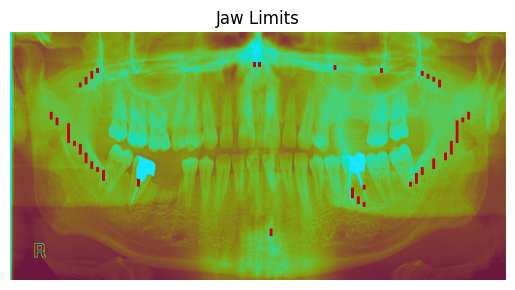

In [ ]:
def plotting(img):
    rows = img.shape[0]
    cols = img.shape[1]
    points = []
    left= []
    right = []
    i = rows - 1
    while i>0:
        if img[i][int(cols/2) -1] == 255:
            i = i -1
        else:
            points.append([i,int(cols/2) -1 ])
            break
    midx = points[0][0]
    midy = points[0][1]
    mid1 = [midx,int(midy + ((cols - midy) /2))]
    mid2 = [midx,int(midy /2)]
    r = midx
    right_point = [0,0]
    left_point = [0,0]

    for i in range(r-1,1,-1):
        midr = mid1[1]
        midl = mid2[1]

        if img[i][midr] == 255 and midr > 0:
            midr = midr - 3
            continue

        if img[i][midl] == 255 and midl > 0:
            midl = midl + 3
            continue
        fr = 0
        fl = 0

        for k in range(midr,int(cols/2),-1):
            if img[i][k] == 255:
                right_point = (i,k)
                right.append([i,k])
                fr = 1
                break

        for j in range(midl,int(cols/2)):
            if j<0:
                break

            if img[i][j] == 255:
                left_point = (i,j)
                left.append([i,j])
                fl = 1
                break

        if fr == 1:
            for m in range(midr,cols-1):
                if img[i][m] == 255:
                    break
            mid1 =[right_point[0],int(right_point[1] + ((m- right_point[1]) /2))]

        if fl == 1:
            for m in range(midl,0,-1):
                if img[i][m] == 255:
                    break
            mid2 =[left_point[0],int((m+left_point[1])/2)]

    return left,right

left, right = plotting(patch_img)
pic_pts = image.copy()

for i, j in left:
    pic_pts[i-1:i+2, j-1:j+2] = [200, 0, 0]
for i, j in right:
    pic_pts[i-1:i+2, j-1:j+2] = [200, 0, 0]

plt.imshow(pic_pts, cmap='gray')
plt.title('Jaw Limits')
plt.axis('off')
plt.show()


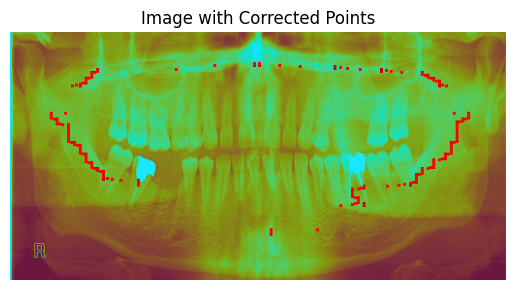

In [ ]:
def correct_points(left,right,img):
    for i in range(1,len(left)-2):
        if (abs(abs(left[i][1] - left[i-1][1]) - abs(left[i][1] - left[i+1][1]))) > 4:
            left[i][1] = int((left[i-1][1] + left[i+1][1]) / 2)

    for i in range(1,len(right)-2):
        if (abs(abs(right[i][1] - right[i-1][1]) - abs(right[i][1] - right[i+1][1]))) > 4:
            right[i][1] = int((right[i-1][1] + right[i+1][1]) / 2)

    corr = np.zeros((img.shape[0],img.shape[1],3))
    for i,j in left:
        corr[i][j] = [255,255,255]
    for i,j in right:
        corr[i][j] = [255,255,255]
    points = left + right
    return points

points = correct_points(left, right, pic_pts)

for i, j in points:
    pic_pts[i-1:i+2, j-1:j+2] = [255, 0, 0]

plt.imshow(pic_pts, cmap='gray')
plt.title('Image with Corrected Points')
plt.axis('off')
plt.show()

In [ ]:
def interchange_x_y(point):
    for i in range(0,len(point)):
        point[i][0],point[i][1] = point[i][1],point[i][0]
    return point

points = interchange_x_y(points)

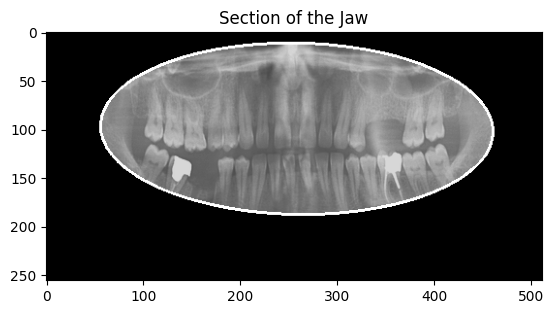

In [ ]:
def fit_ellipse(point,img):
    ellipse = cv2.fitEllipse(np.float32(point))
    im = cv2.ellipse(img,ellipse,255,2)
    return im

ellipse_pts = fit_ellipse(points,img)
for row_idx in range(ellipse_pts.shape[0]):
    for col_idx in range(ellipse_pts.shape[1]):
        if ellipse_pts[row_idx, col_idx] == 255:
            break
        ellipse_pts[row_idx, col_idx] = 0

for row_idx in range(ellipse_pts.shape[0]):
    for col_idx in range(ellipse_pts.shape[1]):
        if ellipse_pts[row_idx, -col_idx] == 255:
            break
        ellipse_pts[row_idx, -col_idx] = 0

plt.imshow(ellipse_pts, cmap='gray')
plt.title('Section of the Jaw')
plt.show()

 Find the highest and lowest points based on x-coordinates as well as the points with the maximum and minimum y-coordinates from a list of points. Additionally, crop a region from an image.

[473, 89] [42, 89]
[269, 209] [252, 33]


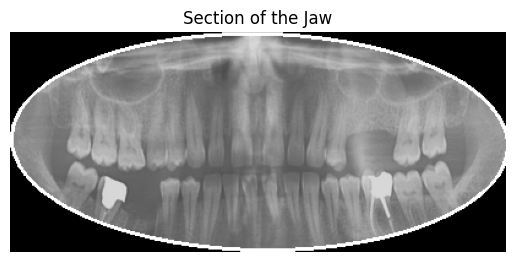

In [ ]:
highest_x_point = max(points, key=lambda p: p[0])
lowest_x_point = min(points, key=lambda p: p[0])
max_y_point = max(points, key=lambda p: p[1])
min_y_point = min(points, key=lambda p: p[1])
print(highest_x_point, lowest_x_point)
print(max_y_point, min_y_point)
cropped = ellipse_pts[10:190,55:460]

plt.imshow(cropped, cmap='gray')
plt.title('Section of the Jaw')
plt.axis('off')
plt.show()

Process a region of interest using vertical projection and identifiy valleys in the projection. Then mark these valleys on the image. Additionally, draw a horizontal line

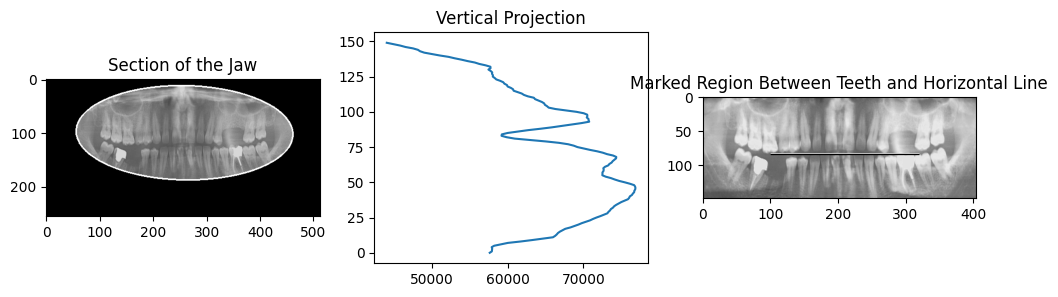

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# extract the region of interest (ROI)
img = contr_image[40:190, 55:460]
jaw_roi = img.copy()

# vertical projection
vertical_projection = np.sum(jaw_roi, axis=1)

threshold_value = 170  # can be adjusted as needed
valley_mask = vertical_projection < threshold_value

valley_indices = find_peaks(-vertical_projection, distance=30)[0]

marked_jaw = jaw_roi.copy()

for i in range(1, len(valley_indices)):
    start_idx = valley_indices[i - 1]
    end_idx = valley_indices[i]
    marked_jaw[start_idx:end_idx, :] = [255, 0, 0]

horizontal_row = 85 # the local minima we got according to graph

# horizontal line
for i in range(100, 320):
  marked_jaw[horizontal_row - 1:horizontal_row + 2, i] = [255, 0, 0]

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.imshow(ellipse_pts, cmap='gray')
plt.title('Section of the Jaw')
plt.subplot(132)
plt.plot(vertical_projection, range(len(vertical_projection)))
plt.title('Vertical Projection')
plt.subplot(133)
plt.imshow(marked_jaw, cmap='gray')
plt.title('Jaw Partition')

plt.show()


Find local minima in the column sum intensities

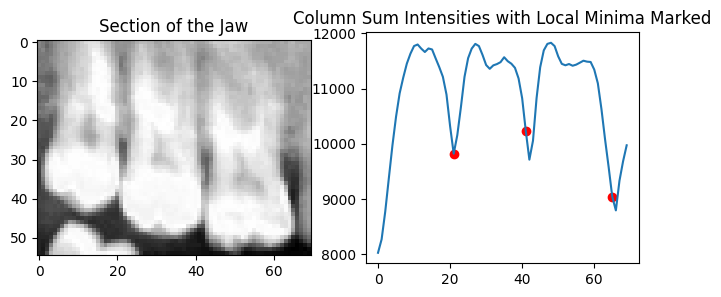

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

img = contr_image[70:125, 100:170]

# column sum intensities
column_sums = np.sum(img, axis=0)

# local minima in the column sum intensities
minima_indices = find_peaks(-column_sums)[0]

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Section of the Jaw')
plt.subplot(132)
plt.plot(range(len(column_sums)), column_sums)
plt.scatter(minima_indices, column_sums[minima_indices], color='red')  # Mark local minima in red
plt.title('Column Sum Intensities with Local Minima Marked')

plt.show()